In [1]:
!gpustat

blade.seas.upenn.edu  Tue Oct 19 22:41:46 2021  455.45.01
[0] RTX A6000        | 84'C,  97 % | 44178 / 48685 MB | gkissas(44175M)
[1] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[2] RTX A6000        | 33'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 34'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 30'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 84'C, 100 % | 44704 / 48685 MB | sifanw(44701M)
[7] RTX A6000        | 35'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax, pmap
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [25]:
path = 'workshop/final_'

In [26]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [27]:
exec(open("../helpers.py").read())

In [28]:
class sampler:
    def __init__(self, X, Y, batch_size):

        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    @partial(jit, static_argnums=(0,))
    def sample(self, key):
        idx = random.choice(key, np.arange(self.X.shape[0]), shape = (batch_size,), replace = False)
        return (self.X[idx], self.Y[idx])

In [29]:
key = random.PRNGKey(1234)

In [30]:
def target_fn_gen(max_freq, key = random.PRNGKey(0)):
    k1, k2 = random.split(key)
    As = random.uniform(k1, shape = (4,2)) * 2
    fs = random.uniform(k2, shape = (4, 4)) * max_freq
    
    def target_fn(X):
        cs = []
        for A, f in zip(As, fs):
            cs.append(A[0] * np.sin(np.pi * f[0] * X[:, 0]) * np.cos(np.pi * f[1] * X[:,1]) + A[1] * np.sin(np.pi * f[2] * X[:, 0]) * np.cos(np.pi * f[3] * X[:,1]))
        return np.array(cs).sum(0)
    return target_fn

In [31]:
max_freq = 36
target_fn = target_fn_gen(max_freq, key = key)

In [32]:
X = random.uniform(key, shape = (2**16, 2), minval = -1, maxval = 1)
Y = target_fn(X)
# Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.01
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

In [33]:
X_test = np.array(np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))).transpose((1,2,0)).reshape(-1,2)
Y_test = target_fn(X_test)

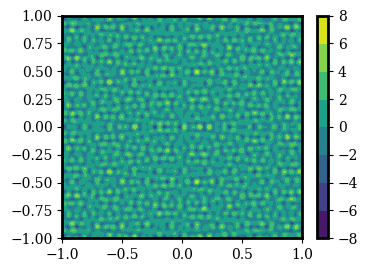

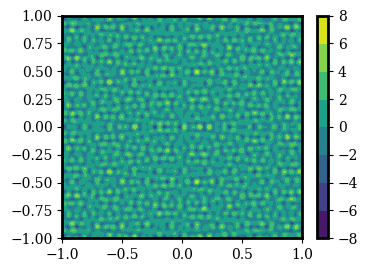

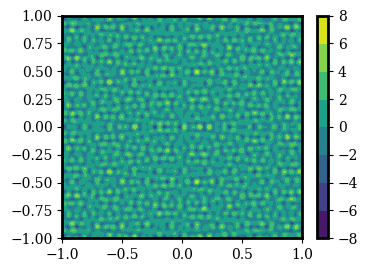

In [34]:
plt.figure(figsize = (4,3))
plt.tricontourf(X_test[:,0], X_test[:,1], Y_test.flatten())
plt.colorbar()
plt.tight_layout()
plt.savefig(path + f'data_size_target_{max_freq}.pdf', dpi = 200)
plt.show()
plt.close()

In [35]:
layers = [X.shape[1], *[256 for _ in range(16)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [36]:
batch_size = 2048
data_sampler = sampler(X, Y, batch_size)

In [37]:
key = random.PRNGKey(0)

In [38]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(5e-4, decay_steps = 400, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [39]:
nIter = 120000

In [53]:
def orthonormal_weights(w):
    if len(w.shape) > 1.1:
        if w.shape[0] == w.shape[1]:
            q,r = onp.linalg.qr(w)

            q = q / np.linalg.norm(q) * np.linalg.norm(w)
            return np.array(q)
        else:
            return w
    else:
        return w

In [54]:
train_errors = []
test_errors = []

init_size = 32

opt_error = jit(lambda opt_states, batch: vmap(fit_model.l2_error, in_axes = [0, None])(vmap(get_params)(opt_states), batch))

data_sizes = 2 ** np.arange(12, 25).astype(int)

for data_size in data_sizes:
    
    X = random.uniform(key, shape = (data_size, 2), minval = -1, maxval = 1)
    Y = target_fn(X)
    # Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.01
    mu_X, sigma_X = X.mean(0), X.std(0)
    X = (X - mu_X) / sigma_X
    mu_Y, sigma_Y = Y.mean(0), Y.std(0)
    Y = (Y - mu_Y) / sigma_Y
    
    data_sampler = sampler(X, Y, batch_size)
    


    init_paramses_list = []
    
    for i in range(20):
        init_paramses_list.append(tree_map(orthonormal_weights, fit_model.net_init(random.PRNGKey(i + data_size))))
    

    init_paramses = tree_multimap(stack_fn, *init_paramses_list)
    opt_states = vmap(init_fn)(init_paramses)

    v_step = jit(vmap(step, in_axes = (None, 0, None)))


    pbar = trange(nIter)
    
        
    for i in pbar:
        mini_batch = data_sampler.sample(random.PRNGKey(i))
        opt_states = v_step(i, opt_states, mini_batch)

    train_errors.append(v_opt_error(opt_states, (X, Y)).reshape(-1,))
    test_errors.append(v_opt_error(opt_states, ((X_test - mu_X) / sigma_X, (Y_test - mu_Y) / sigma_Y)).reshape(-1,))
    np.save(path + f'_data_size_train_test_errors_{max_freq}.npy', np.array((train_errors, test_errors)))
        
train_errors = np.array(train_errors)

test_errors = np.array(test_errors)

  0%|          | 359/120000 [00:08<49:25, 40.35it/s]  


KeyboardInterrupt: 

In [ ]:
train_errors, test_errors = np.load(path + f'_data_size_train_test_errors_{max_freq}.npy')